In [1]:
%matplotlib inline

import glob
import itertools
import matplotlib
from matplotlib import pyplot
import numpy
import os
import pandas
import pysam
import seaborn
import sys

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['agg.path.chunksize'] = 10000
print(f'Package versions:\nPython {sys.version}, matplotlib {matplotlib.__version__}, '
      f'numpy {numpy.__version__}, pandas {pandas.__version__}, '
      f'pysam {pysam.__version__}, seaborn {seaborn.__version__}')

Package versions:
Python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0], matplotlib 3.4.2, numpy 1.21.0, pandas 1.1.5, pysam 0.16.0.1, seaborn 0.11.1


In [2]:
drop_dups = pandas.read_csv('./read_dataframe.csv')
print(drop_dups.shape)
drop_dups.head()

(7469915, 12)


,well_id,r1,r2,seq_corr,edit_type,umi,bc_tracer,het_spacer_offset,bc1_corr,bc2_corr,condition,read_count
0,A1,CACAGTCGCATCATAATCCTCTCTCAAGGGCTTCAAACTCTACTCC...,CCTCCTTTTTCTCTTCCTCTTTCTTTCCTTTTTCTTTCTCCACGTT...,CACAGTCGCATCATAATCCTCTCTCAAGGGCTTCAAACTCTAC,mtND4_HeLa,TTTCTTTCCT,UNKNOWN,0,UNKNOWN,UNKNOWN,UNKNOWN,1
1,A1,CCACAGTCGCATCATAATCCTCTCTCAAGGACTTCAAACTCTACTC...,CCTCCTTTTTCTCTTCCTCTTTTTTTTTCTTTTTTTTCTCCCCTTT...,CACAGTCGCATCATAATCCTCTCTCAAGGACTTCAAACTCTAC,mtND4_293T,TTTTTTTTTC,UNKNOWN,1,UNKNOWN,UNKNOWN,UNKNOWN,1
2,A1,ACGTTCACAGTCGCATCATAATCCTCTCTCAAGGGCTTCAAACTCT...,CCGACGTTTTCTCTTCCTCTCATCTACCGTCCTCGTTCTCCCCTCT...,CACAGTCGCATCATAATCCTCTCTCAAGGGCTTCAAACTCTAC,mtND4_HeLa,TCATCTACCG,UNKNOWN,5,UNKNOWN,UNKNOWN,UNKNOWN,1
3,A1,CCGTCACAGTCGCATCATAATCCTCTCTCAAGGACTTCAAACTCTT...,CCTCCTTTTTCTCTTCCTCTTTTTTCTTTCCTCTTCCATCCCCTTT...,CACAGTCGCATCATAATCCTCTCTCAAGGACTTCAAACTCTAC,mtND4_293T,TTTTTTCTTT,UNKNOWN,4,UNKNOWN,UNKNOWN,UNKNOWN,1
4,A1,ACACAGTCGCATCATAATCCTCTCTCAAGGGCTTCAAACTCTACTC...,CCGCCGTGTGCTCTTCCTCTTTTTCTTTTTCTGCACCCTCCCCGTT...,CACAGTCGCATCATAATCCTCTCTCAAGGGCTTCAAACTCTAC,mtND4_HeLa,TTTTTCTTTT,UNKNOWN,1,UNKNOWN,UNKNOWN,UNKNOWN,1


### Read 1 stat plots

In [3]:
all_stats = drop_dups.groupby('edit_type')['read_count'].sum()
all_stats['TOTAL'] = all_stats.sum()
all_stats = all_stats.rename('read_count').reset_index().sort_values(by='read_count', ascending=False)
all_stats

,edit_type,read_count
3,TOTAL,15680049
2,mtND4_HeLa,7804788
1,mtND4_293T,6970255
0,UNKNOWN,905006


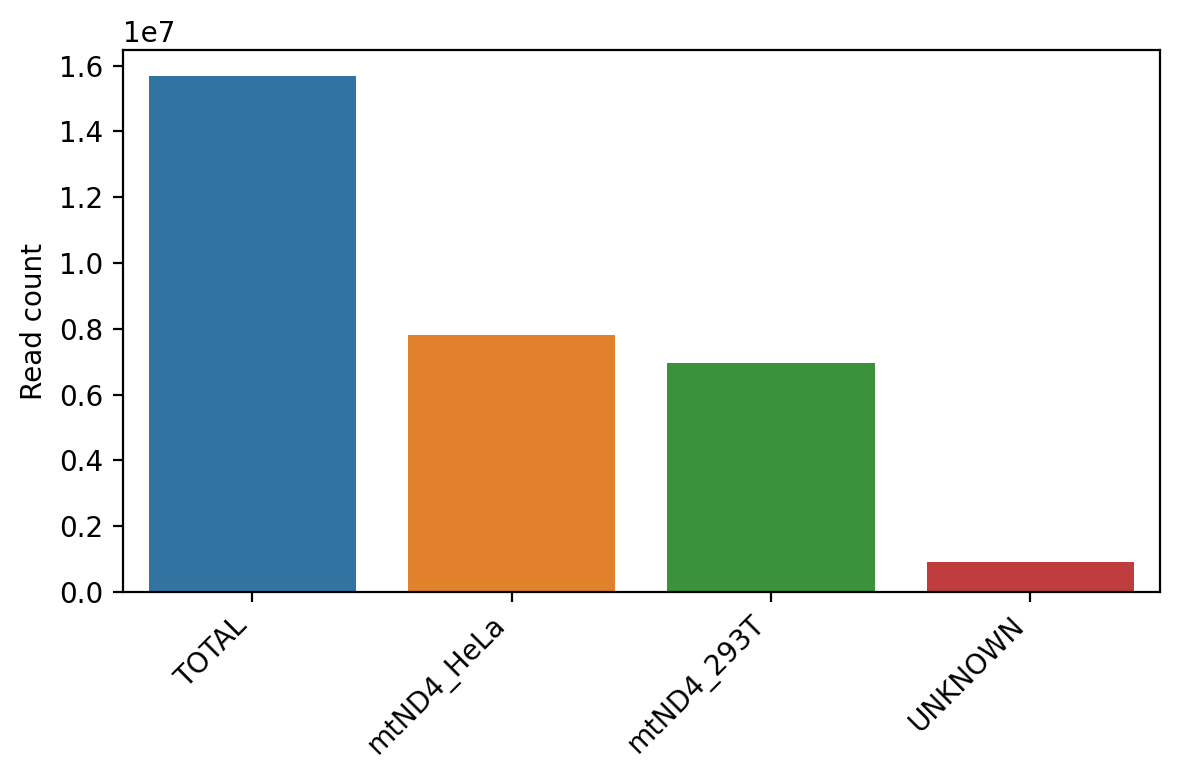

In [4]:
#plot read 1 matches
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))
seaborn.barplot(data=all_stats, x='edit_type', y='read_count', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right', fontsize=10)
axes.set_xlabel('')
axes.set_ylabel('Read count')
fig.tight_layout()

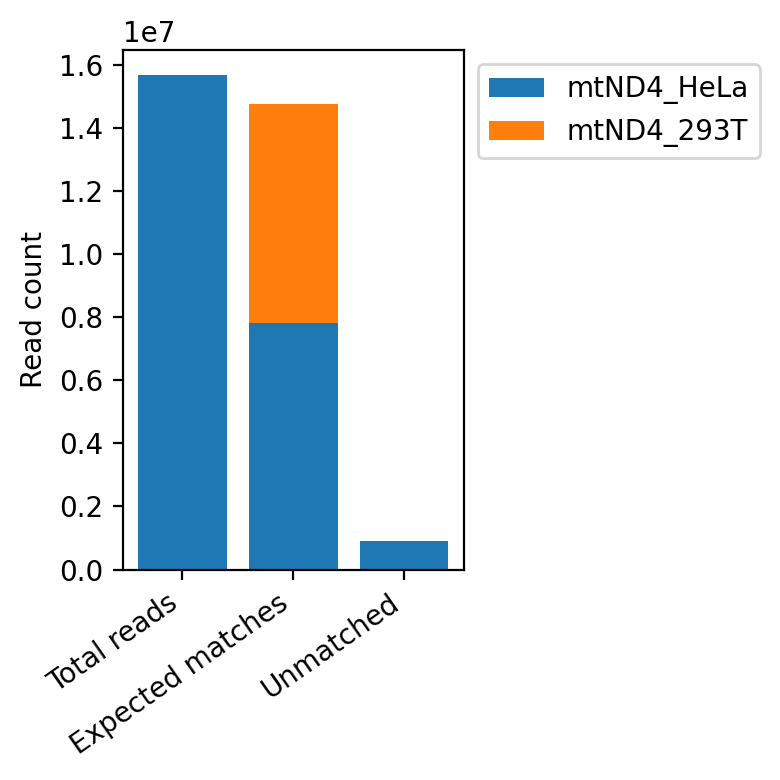

In [5]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(4,4))
axes.bar(x=0, height=all_stats.loc[all_stats['edit_type'] == 'TOTAL', 'read_count'], color='C0')

stacked_indices = ~all_stats['edit_type'].isin(['UNKNOWN', 'TOTAL'])
bottom=0
for r1_name, val in all_stats.loc[stacked_indices].to_numpy():
    axes.bar(x=1, height=val, bottom=bottom, label=r1_name)
    bottom += val

axes.bar(x=2, height=all_stats.loc[all_stats['edit_type'] == 'UNKNOWN', 'read_count'], color='C0')

axes.set_xticks(numpy.arange(3))
axes.set_xticklabels(['Total reads', 'Expected matches', 'Unmatched'], ha='right', rotation=35)
axes.set_ylabel('Read count')
axes.legend(bbox_to_anchor=[1,1])
fig.tight_layout()

### Read 2 stat plots

In [6]:
all_stats = drop_dups.groupby('condition')['read_count'].sum()
all_stats['TOTAL'] = all_stats.sum()
order = ['TOTAL', 'UNKNOWN'] + sorted(all_stats.loc[~all_stats.index.isin(['TOTAL', 'UNKNOWN'])].index.values)
all_stats = all_stats.loc[order].rename('read_count').reset_index()
all_stats

,condition,read_count
0,TOTAL,15680049
1,UNKNOWN,3075757
2,293T,4914712
3,HeLa,5108708
4,mixed,2580872


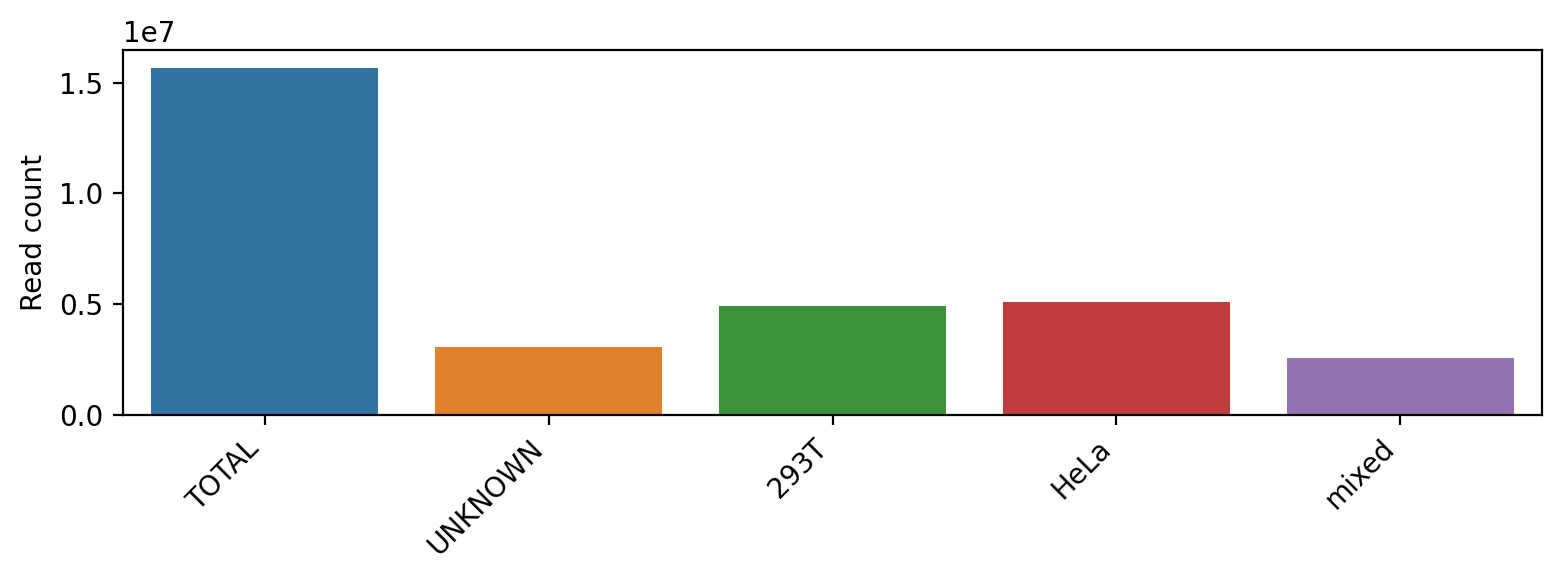

In [7]:
#plot read 2 matches
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,3))
seaborn.barplot(data=all_stats, x='condition', y='read_count', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right', fontsize=10)
axes.set_xlabel('')
axes.set_ylabel('Read count')
fig.tight_layout()

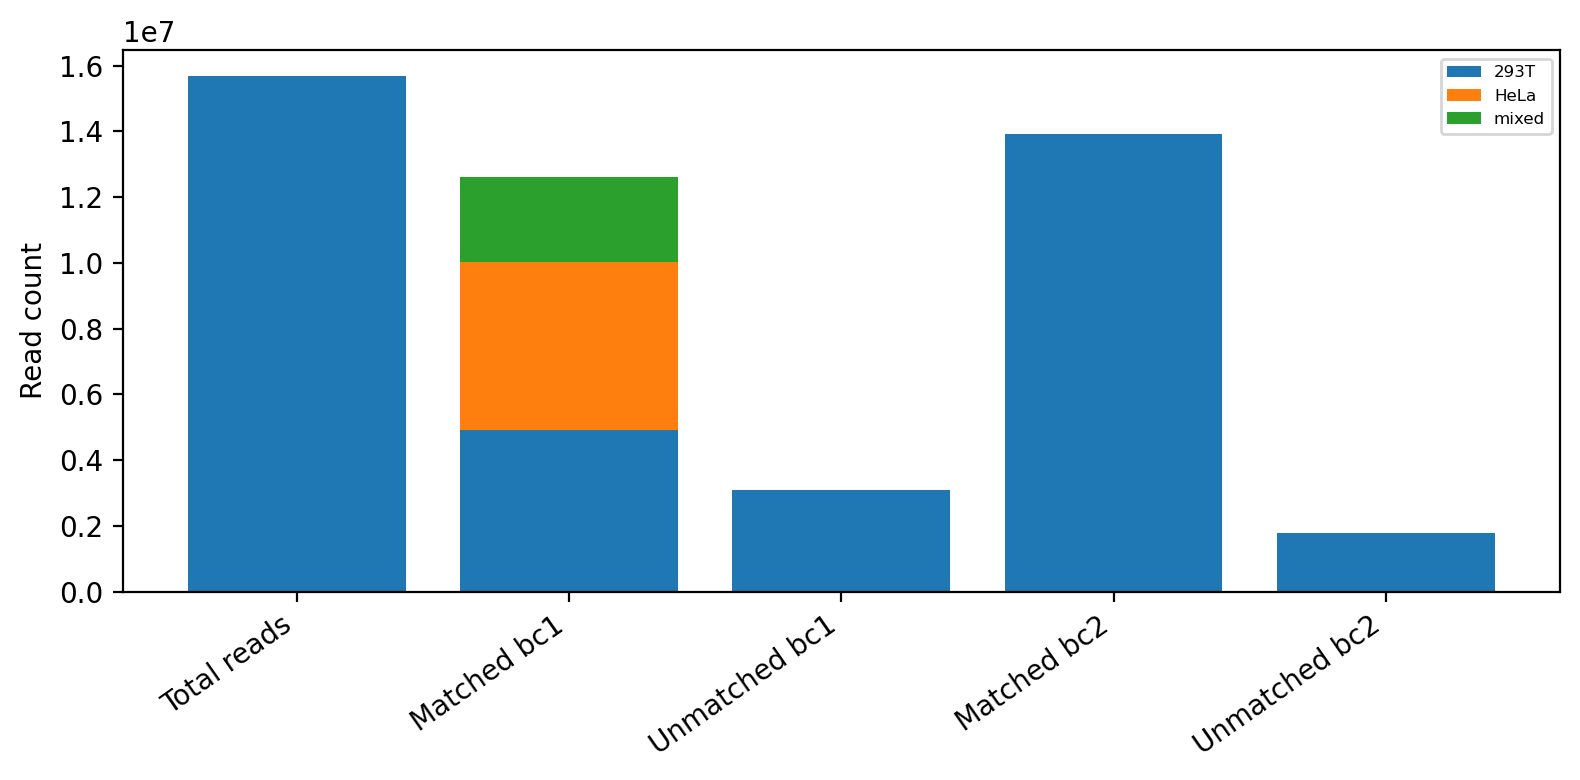

In [8]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,4))
axes.bar(x=0, height=all_stats.loc[all_stats['condition'] == 'TOTAL', 'read_count'], color='C0')

stacked_indices = ~all_stats['condition'].isin(['UNKNOWN', 'TOTAL'])
bottom=0
for r1_name, val in all_stats.loc[stacked_indices].to_numpy():
    axes.bar(x=1, height=val, bottom=bottom, label=r1_name)
    bottom += val

axes.bar(x=2, height=all_stats.loc[all_stats['condition'] == 'UNKNOWN', 'read_count'], color='C0')

axes.bar(x=3, height=drop_dups.loc[drop_dups['bc2_corr'] != 'UNKNOWN', 'read_count'].sum(), color='C0')
axes.bar(x=4, height=drop_dups.loc[drop_dups['bc2_corr'] == 'UNKNOWN', 'read_count'].sum(), color='C0')

axes.set_xticks(numpy.arange(5))
axes.set_xticklabels(['Total reads', 'Matched bc1', 'Unmatched bc1', 
                      'Matched bc2', 'Unmatched bc2'], ha='right', rotation=35)
axes.set_ylabel('Read count')
axes.legend(bbox_to_anchor=[1,1], fontsize=6)
fig.tight_layout()

In [9]:
collapse_umis = pandas.read_csv('./umi_dataframe.csv')
per_cell = pandas.concat([collapse_umis.groupby(['cell_id', 'condition']).size().rename('umi_count'),
                          (collapse_umis.groupby(['cell_id', 'condition'])['edit_type'].value_counts().rename('count')
                           .reset_index()
                           .pivot(index=['cell_id', 'condition'], columns='edit_type', values='count')
                           .fillna(0))], axis=1).reset_index()

per_cell['mtDNA_umi_count'] = per_cell[['mtND4_HeLa', 'mtND4_293T']].sum(axis=1)
per_cell['rank'] = per_cell.shape[0] - numpy.argsort(numpy.argsort(per_cell['umi_count'].to_numpy()))
print('Number of detected unique barcode combos: {!s}'.format(per_cell.shape))
per_cell.head()

Number of detected unique barcode combos: (5931, 7)


,cell_id,condition,umi_count,mtND4_293T,mtND4_HeLa,mtDNA_umi_count,rank
0,A1-AAACATCG-CTAACGAG,293T,128,128.0,0.0,128.0,1645
1,A1-AAACATCG-GCATTCTA,293T,117,117.0,0.0,117.0,1897
2,A1-AAACATCG-GTGTATAG,293T,1,1.0,0.0,1.0,4683
3,A1-AAACATCG-GTTGCTGT,293T,1,1.0,0.0,1.0,4684
4,A1-AAACATCG-TAATCGGC,293T,1,1.0,0.0,1.0,4685


In [12]:
max_cells = 6000
origin_dist = numpy.sqrt(numpy.log10(per_cell.loc[per_cell['rank'] <= max_cells, 'umi_count'].to_numpy())**2
                         + numpy.log10(per_cell.loc[per_cell['rank'] <= max_cells, 'rank'].to_numpy())**2)
knee_thresh = per_cell.loc[per_cell['rank'] <= max_cells, 'umi_count'].to_numpy()[numpy.argmax(origin_dist)]
valid_cells = per_cell.loc[per_cell['umi_count'] >= knee_thresh].copy()
print('{!s} valid cells detected with at least {!s} UMIs'
      .format(valid_cells.shape[0], knee_thresh))

3208 valid cells detected with at least 64 UMIs


In [13]:
per_cell['valid_cell'] = (per_cell['umi_count'] >= knee_thresh)

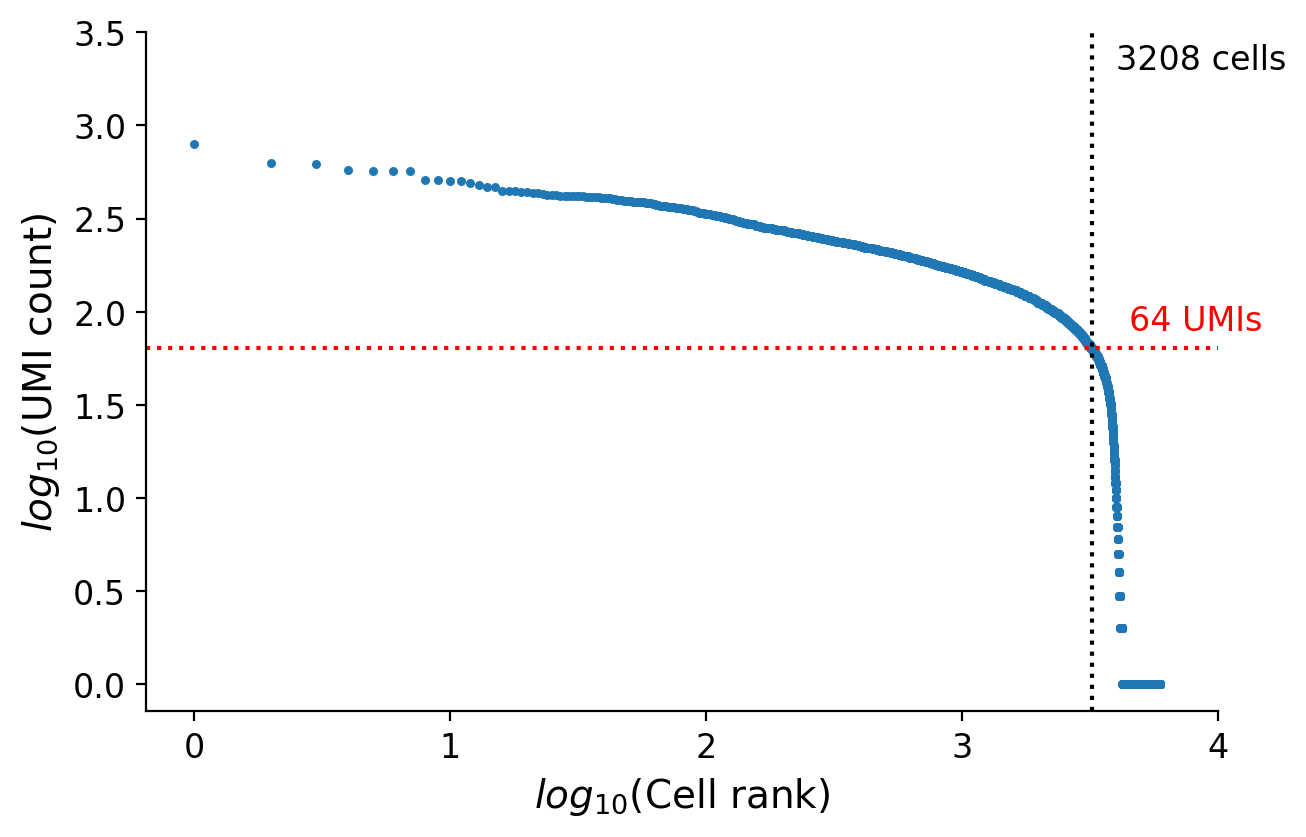

In [14]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))

for spine in ['top', 'right']:
    axes.spines[spine].set_visible(False)

axes.scatter(numpy.log10(per_cell['rank']), numpy.log10(per_cell['umi_count']), s=5)
axes.axvline(numpy.log10(numpy.sum(per_cell['umi_count'] >= 64)), color='k', linestyle='dotted')
axes.axhline(numpy.log10(64), color='red', linestyle='dotted')
axes.annotate('3208 cells', (3.6, 3.3), color='k', fontsize=12)
axes.annotate('64 UMIs', (3.65, 1.9), color='r', fontsize=12)
axes.set_xlabel('$log_{10}$(Cell rank)', fontsize=14)
xticks = numpy.arange(5)
axes.set_xticks(xticks)
axes.set_xticklabels(xticks.astype(str), fontsize=12)

axes.set_ylabel('$log_{10}$(UMI count)', fontsize=14)
yticks = numpy.arange(0,4,0.5)
axes.set_yticks(yticks)
axes.set_yticklabels(yticks.astype(str), fontsize=12)
fig.savefig('./barnyard_knee_plot.pdf', bbox_inches='tight')
fig.tight_layout()

In [15]:
valid_cells = pandas.read_csv('heteroplasmy_dataframe.csv')
valid_cells.columns = valid_cells.columns.str.replace('_HET', '_het')
print(valid_cells.shape)
valid_cells.head()

(3208, 10)


,cell_id,condition,umi_count,293T,HeLa,umi_count_for_filtering,umi_count_rank,293T_het,HeLa_het,total_het
0,A1-AACAACCA-GAGACAGC,mixed,235,0,235,235,347,0.0,1.0,1.0
1,A1-AACAACCA-GTTGCTGT,mixed,151,151,0,151,1181,1.0,0.0,1.0
2,A1-CGCTGATC-GTCCGACC,HeLa,169,0,169,169,923,0.0,1.0,1.0
3,A1-AACGTGAT-GTTATGGT,293T,318,318,0,318,121,1.0,0.0,1.0
4,A1-CTGTAGCC-TATTCATA,mixed,210,0,210,210,507,0.0,1.0,1.0


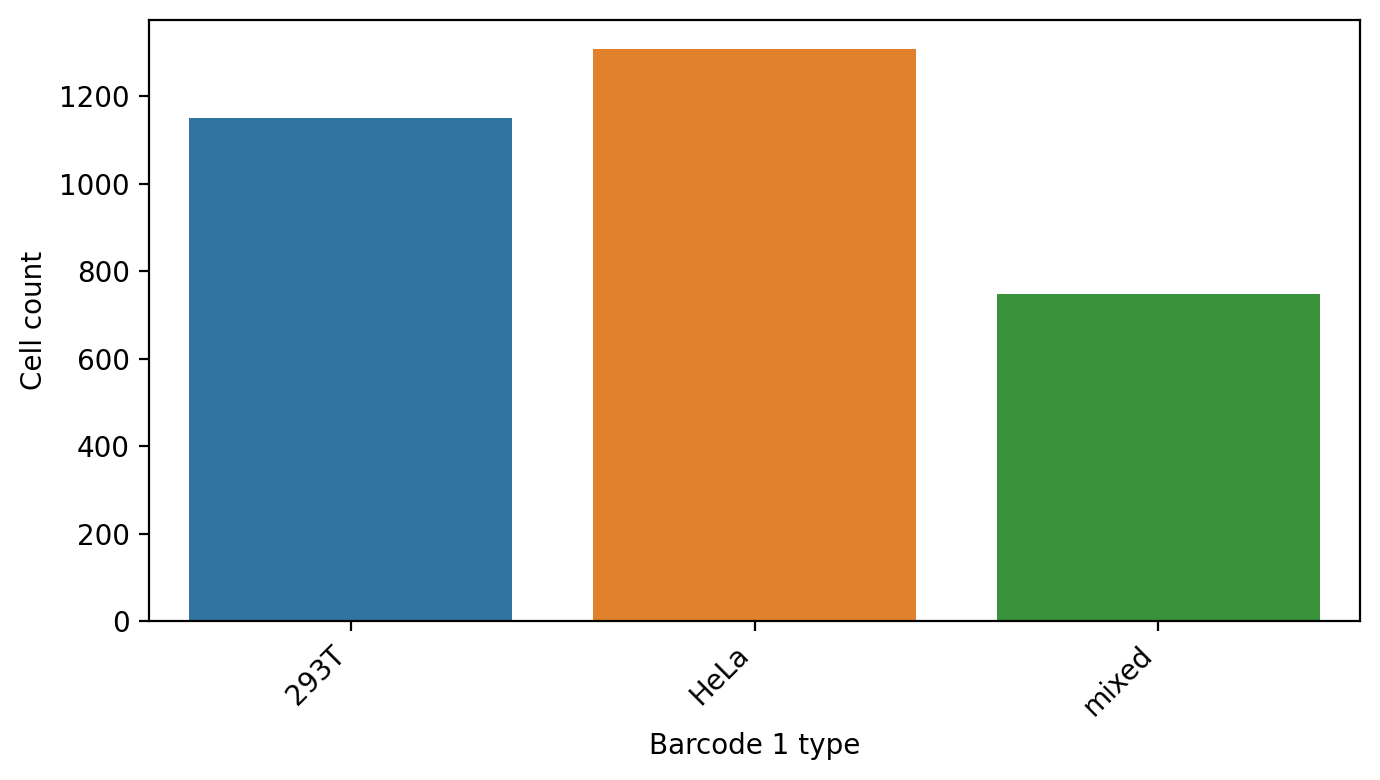

In [16]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(7,4))
xorder = sorted(valid_cells['condition'].unique())
seaborn.countplot(data=valid_cells, x='condition', order=xorder, ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
axes.set_ylabel('Cell count')
axes.set_xlabel('Barcode 1 type')
fig.tight_layout()

### Annotate cells with cell type and doublet status. Use an absolute UMI threshold defined based on the arms of the experiment that contain unmixed cells.

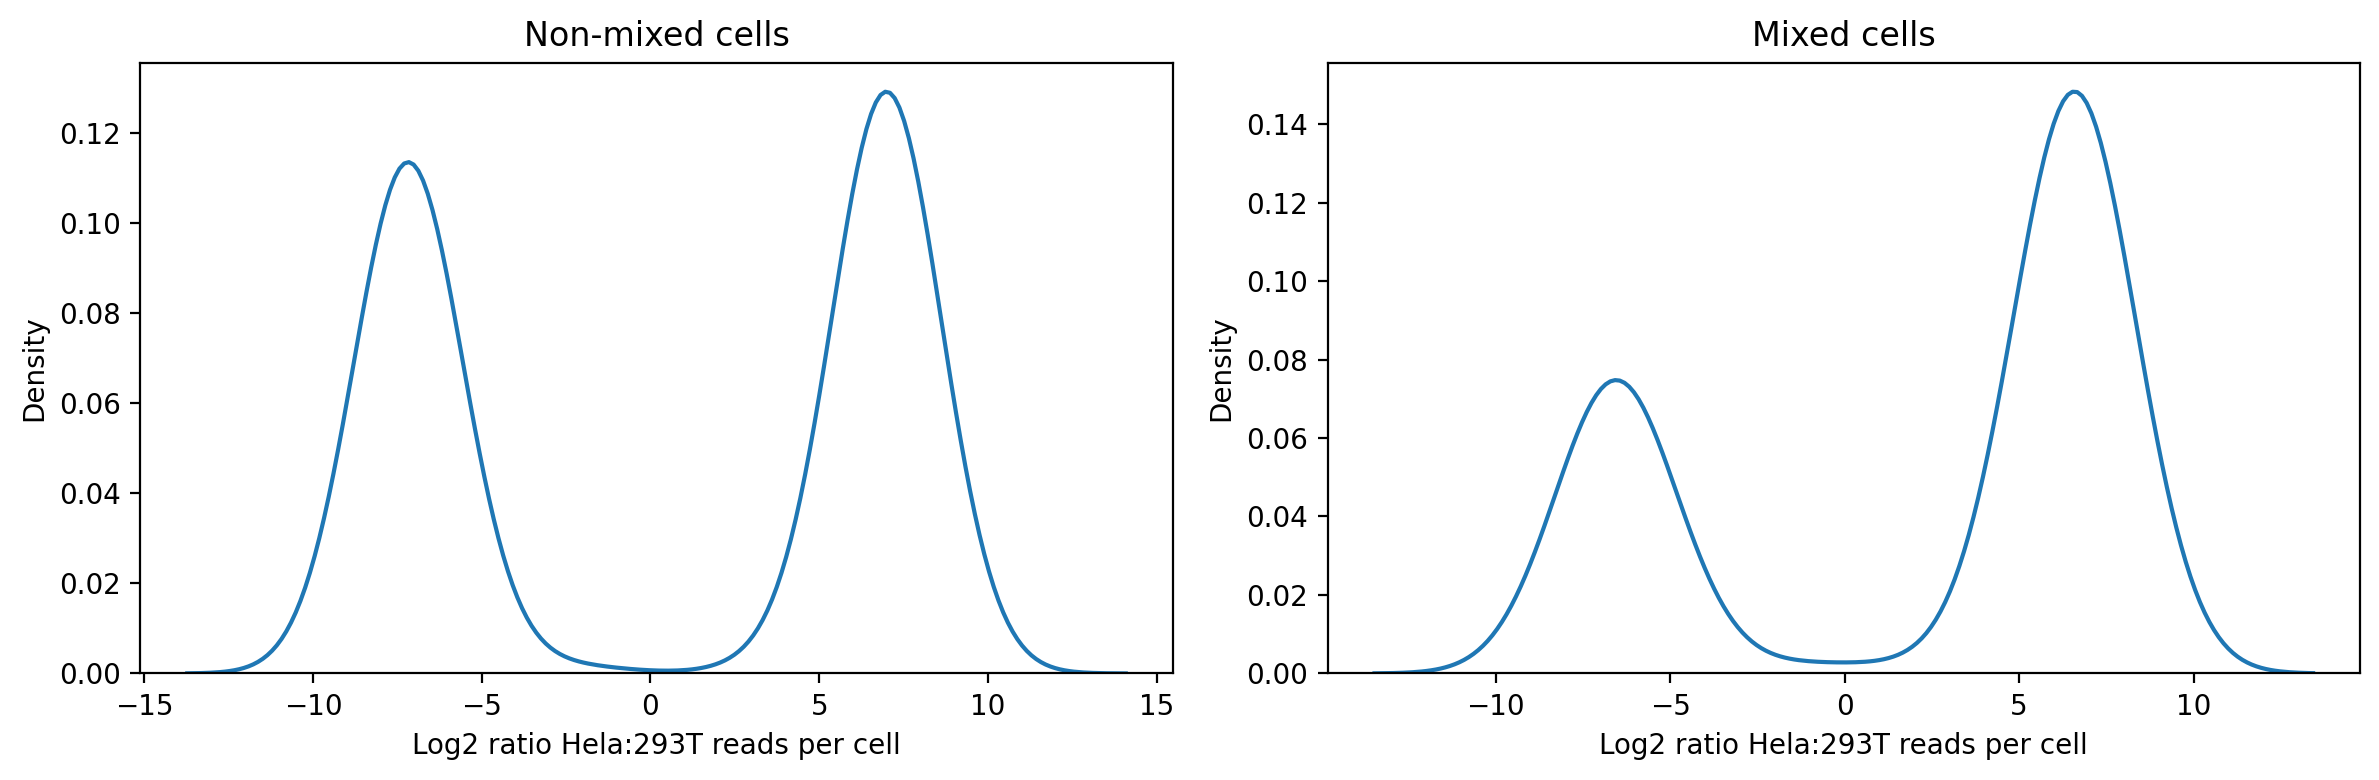

In [17]:
valid_cells['HeLa_log2ratio'] = numpy.log2(valid_cells['HeLa']+1) - numpy.log2(valid_cells['293T'] + 1)

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(12,4))
seaborn.kdeplot(x=valid_cells.loc[valid_cells['condition'] !='mixed', 'HeLa_log2ratio'].to_numpy(), ax=axes[0])
axes[0].set_xlabel('Log2 ratio Hela:293T reads per cell')
axes[0].set_title('Non-mixed cells')

seaborn.kdeplot(x=valid_cells.loc[valid_cells['condition'] =='mixed', 'HeLa_log2ratio'].to_numpy(), ax=axes[1])
axes[1].set_xlabel('Log2 ratio Hela:293T reads per cell')
axes[1].set_title('Mixed cells')

fig.tight_layout()

In [29]:
doublet_threshold = numpy.max(numpy.hstack([valid_cells.loc[valid_cells['condition'] == '293T', 'HeLa'],
                                            valid_cells.loc[valid_cells['condition'] == 'HeLa', '293T']]))
print(f'Doublet threshold: {doublet_threshold} UMIs')
doublets_idx = (((valid_cells['HeLa_log2ratio'] < 0) & (valid_cells['HeLa'] > doublet_threshold))
                | ((valid_cells['HeLa_log2ratio'] > 0) & (valid_cells['293T'] > doublet_threshold)))
valid_cells.loc[doublets_idx, 'cell_type2'] = 'doublet'
valid_cells.loc[~doublets_idx & (valid_cells['HeLa'] > valid_cells['293T']), 'cell_type2'] = 'HeLa'
valid_cells.loc[~doublets_idx & (valid_cells['HeLa'] < valid_cells['293T']), 'cell_type2'] = '293T'

Doublet threshold: 29 UMIs


In [30]:
doublets_idx2 = (per_cell['valid_cell'] 
                 & (((per_cell['HeLa_log2ratio'] < 0) & (per_cell['mtND4_HeLa'] > doublet_threshold))
                    | ((per_cell['HeLa_log2ratio'] > 0) & (per_cell['mtND4_293T'] > doublet_threshold))))
per_cell['cell_type2'] = 'unassigned'
per_cell.loc[doublets_idx2, 'cell_type2'] = 'doublet'
per_cell.loc[per_cell['valid_cell'] & ~doublets_idx2 & (per_cell['mtND4_HeLa'] > per_cell['mtND4_293T']), 'cell_type2'] = 'HeLa'
per_cell.loc[per_cell['valid_cell'] & ~doublets_idx2 & (per_cell['mtND4_HeLa'] < per_cell['mtND4_293T']), 'cell_type2'] = '293T'

per_cell.head()

,cell_id,condition,umi_count,mtND4_293T,mtND4_HeLa,mtDNA_umi_count,rank,valid_cell,HeLa_log2ratio,cell_type,cell_type2
0,A1-AAACATCG-CTAACGAG,293T,128,128.0,0.0,128.0,1645,True,-7.011227,293T,293T
1,A1-AAACATCG-GCATTCTA,293T,117,117.0,0.0,117.0,1897,True,-6.882643,293T,293T
2,A1-AAACATCG-GTGTATAG,293T,1,1.0,0.0,1.0,4683,False,-1.000000,unassigned,unassigned
3,A1-AAACATCG-GTTGCTGT,293T,1,1.0,0.0,1.0,4684,False,-1.000000,unassigned,unassigned
4,A1-AAACATCG-TAATCGGC,293T,1,1.0,0.0,1.0,4685,False,-1.000000,unassigned,unassigned


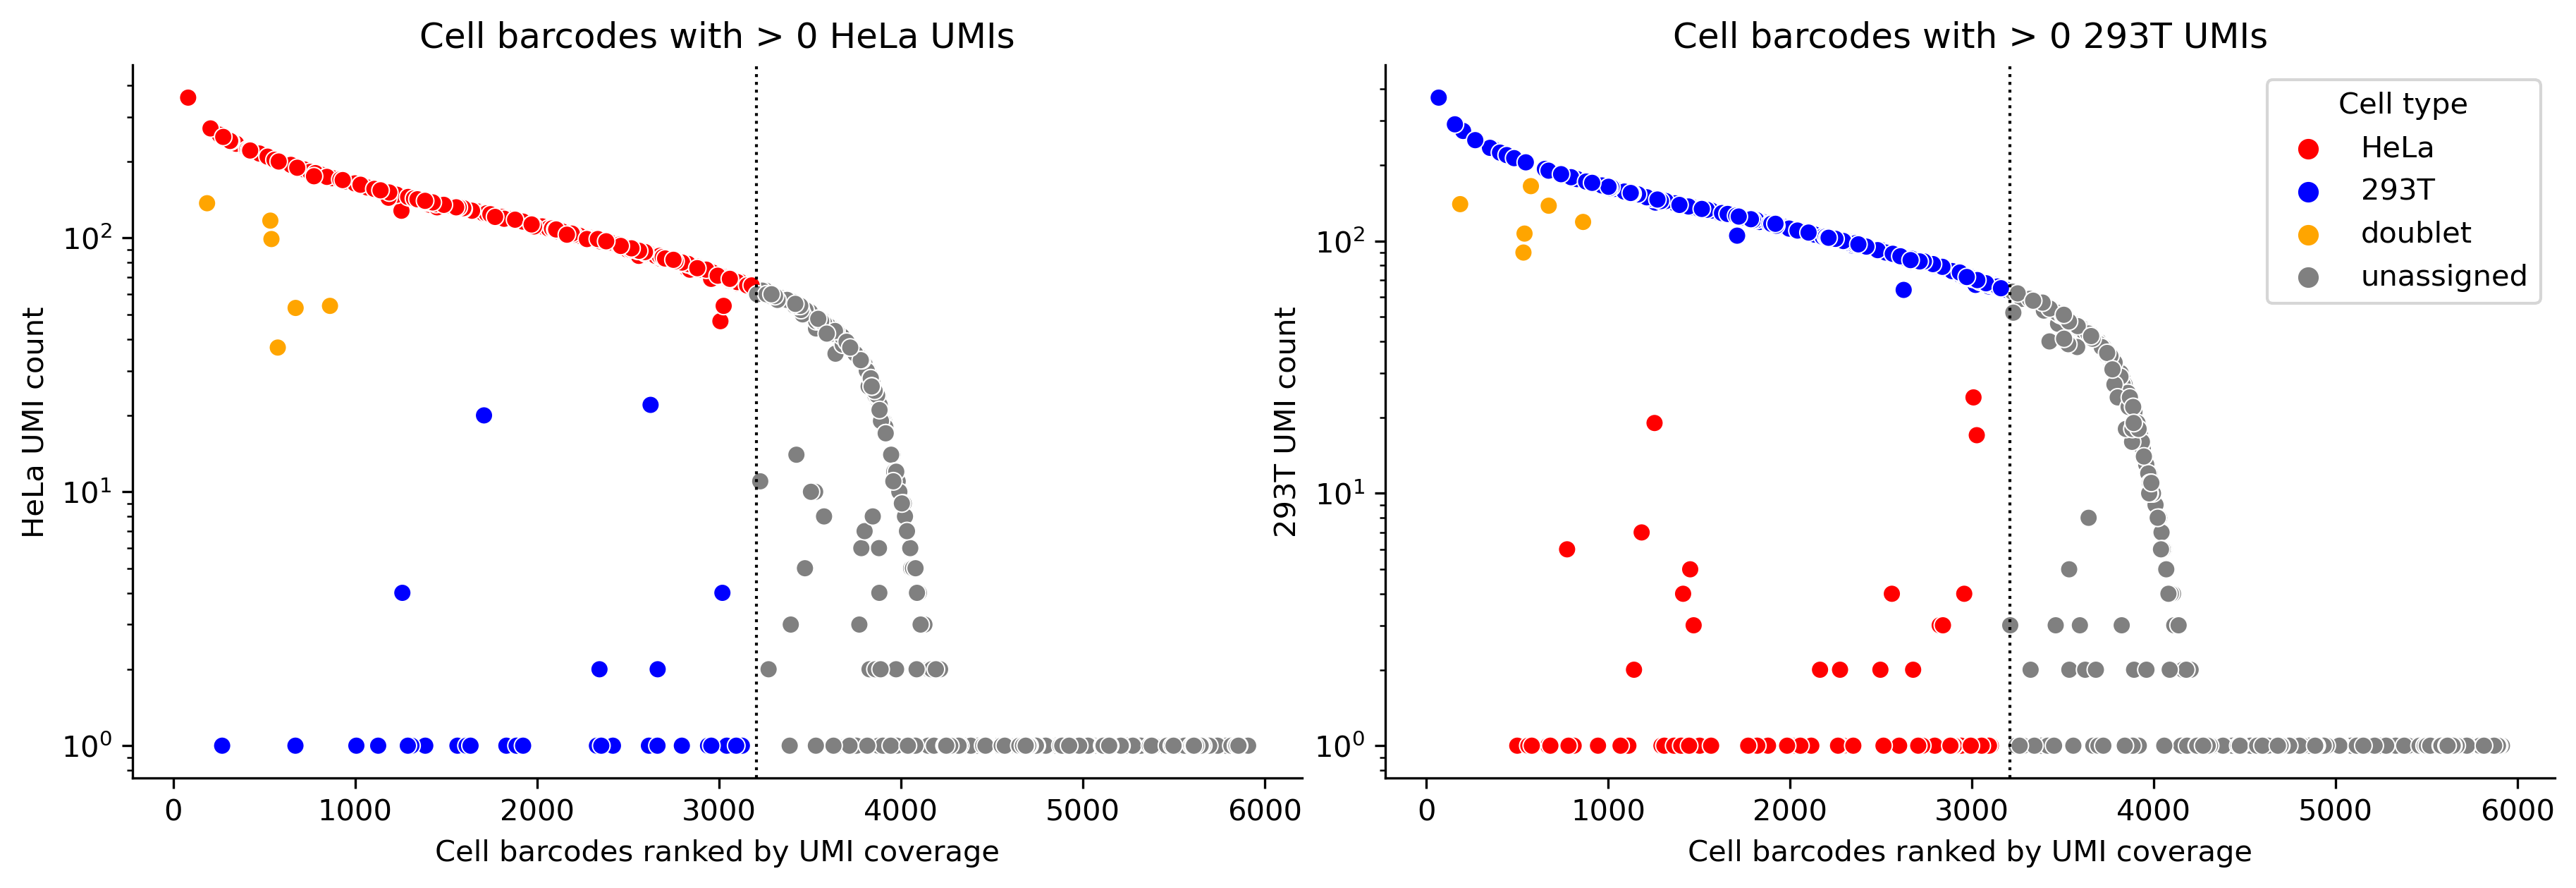

In [31]:
to_plot = per_cell[per_cell['condition'] == 'mixed'].copy()

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=300)
hue_order = ['HeLa', '293T', 'doublet', 'unassigned']
palette = ['red', 'blue', 'orange', 'grey']
seaborn.scatterplot(data=to_plot, x='rank', y='mtND4_HeLa', hue='cell_type2', 
                    hue_order=hue_order, palette=palette, ax=axes[0], legend=False)
axes[0].axvline(3208, color='k', linestyle='dotted', linewidth=1)
axes[0].set_ylabel('HeLa UMI count')
axes[0].set_title('Cell barcodes with > 0 HeLa UMIs')

seaborn.scatterplot(data=to_plot, x='rank', y='mtND4_293T', hue='cell_type2', 
                    hue_order=hue_order, palette=palette, ax=axes[1])
axes[1].axvline(3208, color='k', linestyle='dotted', linewidth=1)
axes[1].set_ylabel('293T UMI count')
axes[1].set_title('Cell barcodes with > 0 293T UMIs')

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, loc='upper right', title='Cell type')

for ax in axes:
    ax.set_xlabel('Cell barcodes ranked by UMI coverage')
    ax.set_yscale('log')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.savefig('./ambient_rna_plot.pdf', bbox_inches='tight')
fig.tight_layout()

In [32]:
not_mix = valid_cells[valid_cells['condition'] != 'mixed'].copy()
ct_counts = pandas.concat([not_mix['cell_type2'].value_counts().rename('cell_count'), 
                           not_mix['cell_type2'].value_counts(normalize=True).rename('cell_pct')*100], axis=1)
ct_counts

,cell_count,cell_pct
HeLa,1309,53.211382
293T,1151,46.788618


In [33]:
just_mix = valid_cells[valid_cells['condition'] == 'mixed'].copy()
ct_counts = pandas.concat([just_mix['cell_type2'].value_counts().rename('cell_count'), 
                           just_mix['cell_type2'].value_counts(normalize=True).rename('cell_pct')*100], axis=1)
ct_counts

,cell_count,cell_pct
HeLa,494,66.042781
293T,248,33.155080
doublet,6,0.802139


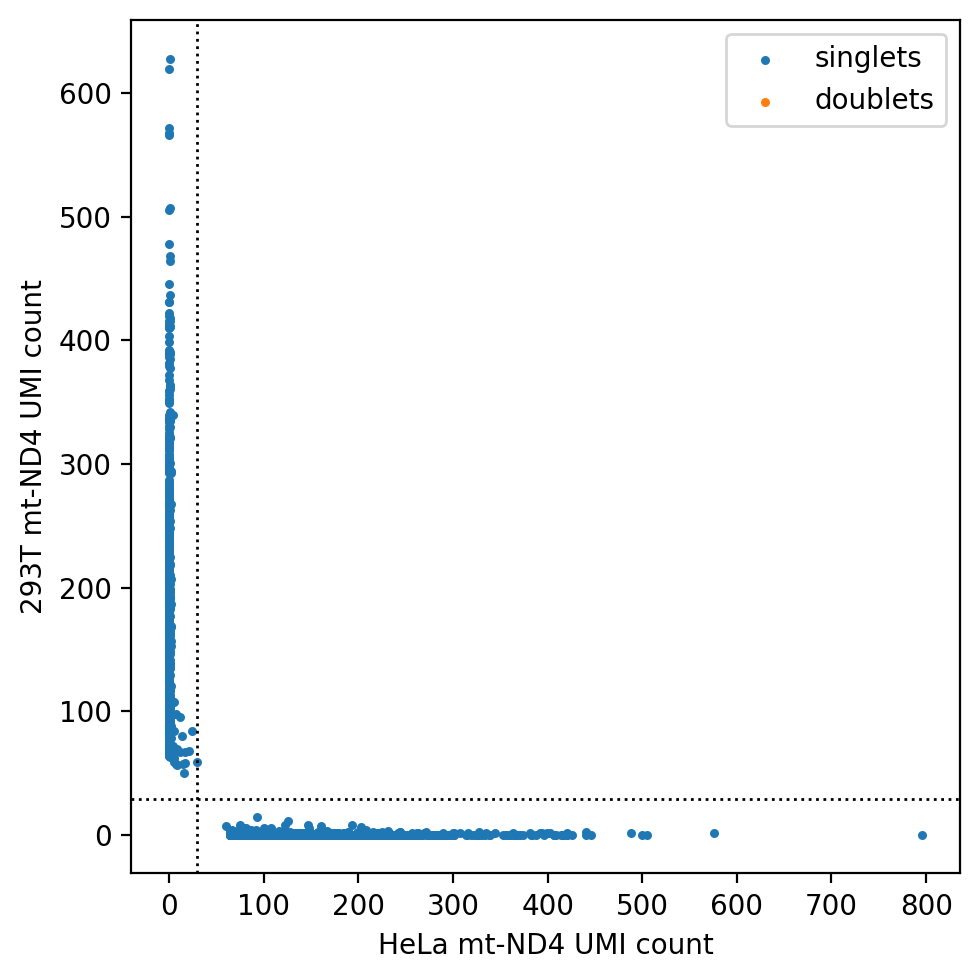

In [34]:
just_sep = valid_cells[valid_cells['condition'] != 'mixed'].copy()

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(5,5))
axes.scatter(just_sep.loc[just_sep['cell_type2'] != 'doublet', 'HeLa'], 
             just_sep.loc[just_sep['cell_type2'] != 'doublet', '293T'], s=5, label='singlets')
axes.scatter(just_sep.loc[just_sep['cell_type2'] == 'doublet', 'HeLa'],
             just_sep.loc[just_sep['cell_type2'] == 'doublet', '293T'], s=5, label='doublets')
axes.axhline(doublet_threshold, color='k', linewidth=1, linestyle='dotted')
axes.axvline(doublet_threshold, color='k', linewidth=1, linestyle='dotted')
axes.set_xlabel('HeLa mt-ND4 UMI count')
axes.set_ylabel('293T mt-ND4 UMI count')
axes.legend(loc='best')
fig.tight_layout()

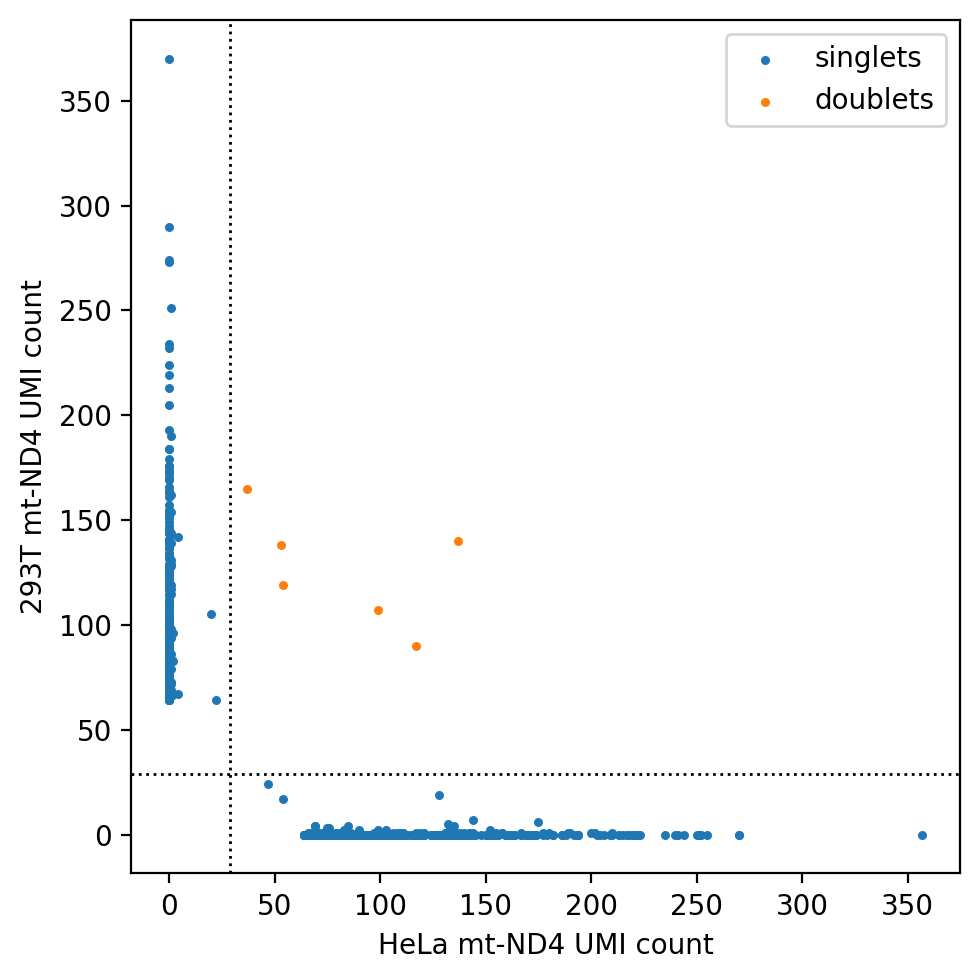

In [35]:
just_mix = valid_cells[valid_cells['condition'] == 'mixed'].copy()

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(5,5))
axes.scatter(just_mix.loc[just_mix['cell_type2'] != 'doublet', 'HeLa'], 
             just_mix.loc[just_mix['cell_type2'] != 'doublet', '293T'], s=5, label='singlets')
axes.scatter(just_mix.loc[just_mix['cell_type2'] == 'doublet', 'HeLa'],
             just_mix.loc[just_mix['cell_type2'] == 'doublet', '293T'], s=5, label='doublets')
axes.axhline(doublet_threshold, color='k', linewidth=1, linestyle='dotted')
axes.axvline(doublet_threshold, color='k', linewidth=1, linestyle='dotted')
axes.set_xlabel('HeLa mt-ND4 UMI count')
axes.set_ylabel('293T mt-ND4 UMI count')
axes.legend(loc='best')
fig.tight_layout()

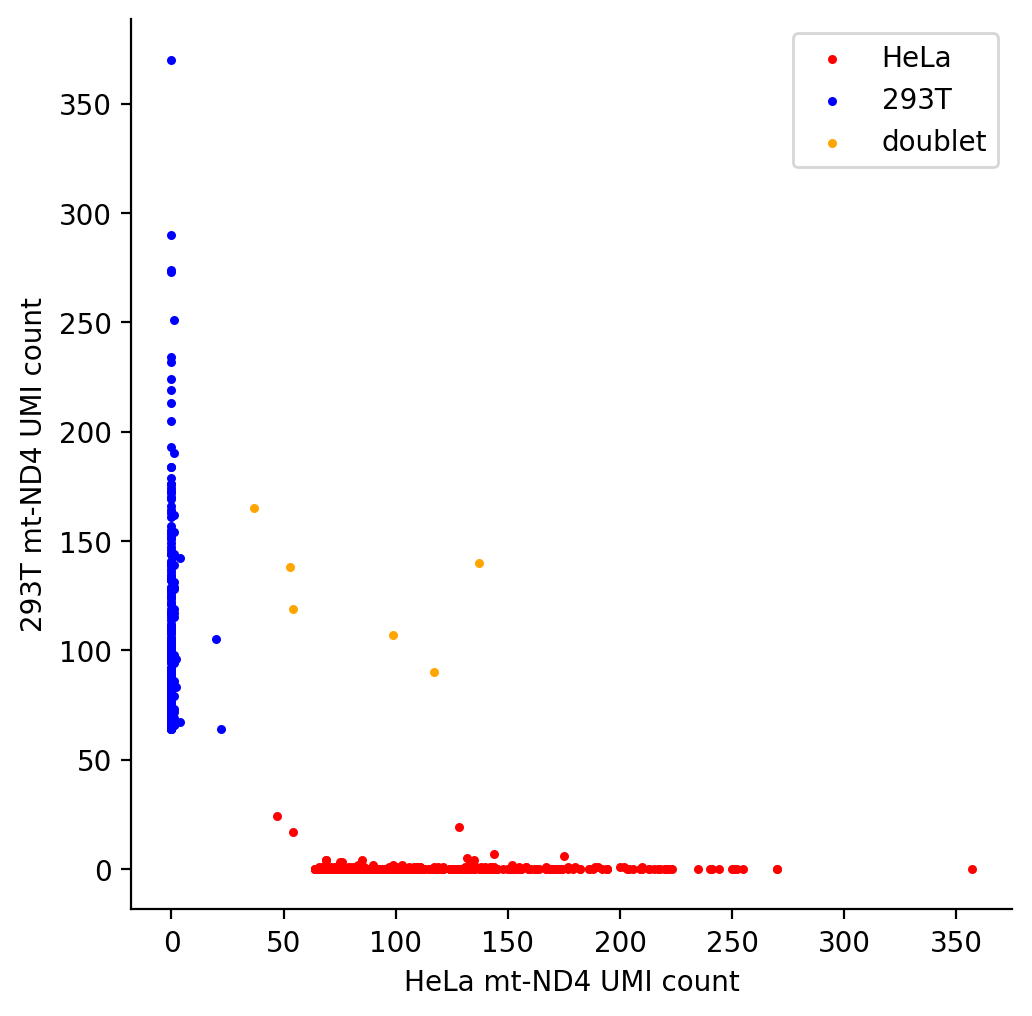

In [38]:
just_mix = valid_cells[valid_cells['condition'] == 'mixed'].copy()

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(5,5))
axes.scatter(just_mix.loc[just_mix['cell_type2'] == 'HeLa', 'HeLa'],
             just_mix.loc[just_mix['cell_type2'] == 'HeLa', '293T'], s=5, color='red', label='HeLa')
axes.scatter(just_mix.loc[just_mix['cell_type2'] == '293T', 'HeLa'],
             just_mix.loc[just_mix['cell_type2'] == '293T', '293T'], s=5, color='blue', label='293T')
axes.scatter(just_mix.loc[just_mix['cell_type2'] == 'doublet', 'HeLa'],
             just_mix.loc[just_mix['cell_type2'] == 'doublet', '293T'], s=5, color='orange', label='doublet')
axes.set_xlabel('HeLa mt-ND4 UMI count')
axes.set_ylabel('293T mt-ND4 UMI count')
for spine in ['top', 'right']:
    axes.spines[spine].set_visible(False)
axes.legend(loc='best')
fig.savefig('./barnyard_scatter_plot_cell_type_colors.pdf', bbox_inches='tight')
fig.tight_layout()

### Check the expected number of homotypic doublets given our a priori expected full doublet rate of 2%.

In [39]:
type_idx = (valid_cells['condition'] == 'mixed') & (valid_cells['cell_type2'] != 'doublet')
#compute the fractional composition of cell types in the SCI-LITE output
ct_fracs = valid_cells.loc[type_idx, 'cell_type2'].value_counts(normalize=True).rename('ct_frac').reset_index()
#the homotypic doublet probability is the chance of making two random draws of the same sequence of wells
ct_fracs['homotypic_prob'] = ct_fracs['ct_frac'] ** 2
ct_fracs

,index,ct_frac,homotypic_prob
0,HeLa,0.665768,0.443247
1,293T,0.334232,0.111711


In [40]:
# estimated doublet rate
est_dbl_rate = 0.02

#initialize dataframe fields
pct_umi_thresh_df = {'condition':[],
                     'ct':[],
                     'ct_count':[],
                     'ct_frac':[],
                     'umi_threshold':[],
                     'homotypic_prob':[],
                     'homotypic_count':[]}
#compute homotypic probability and expected homotypic doublet counts in each arm of the SCI-LITE experiment
for condition in ['293T', 'HeLa', 'mixed']:
    type_idx = (valid_cells['condition'] == condition) & (valid_cells['cell_type2'] != 'doublet')
    ct_fracs = valid_cells.loc[type_idx, 'cell_type2'].value_counts(normalize=True).rename('ct_frac').reset_index()
    ct_fracs['homotypic_prob'] = ct_fracs['ct_frac'] ** 2
    het_prob = 1.0 - numpy.sum(ct_fracs['homotypic_prob'])
    print(condition, het_prob)
    for ct, ct_frac, homotyp_prob in ct_fracs.to_numpy():
        ct_idx = valid_cells.loc[type_idx, 'cell_type2'] == ct
        pct_num = int(numpy.ceil(valid_cells[type_idx & ct_idx].shape[0] * (est_dbl_rate * homotyp_prob)))
        if pct_num == 0:
            continue
        pct_umi_thresh = sorted(valid_cells.loc[type_idx & ct_idx, 'umi_count_for_filtering'].to_numpy())[0-pct_num] - 1
        pct_umi_thresh_df['condition'].append(condition)
        pct_umi_thresh_df['ct'].append(ct)
        pct_umi_thresh_df['ct_count'].append(numpy.sum(ct_idx))
        pct_umi_thresh_df['ct_frac'].append(ct_frac)
        pct_umi_thresh_df['umi_threshold'].append(pct_umi_thresh)
        pct_umi_thresh_df['homotypic_prob'].append(homotyp_prob)
        pct_umi_thresh_df['homotypic_count'].append(pct_num)

pct_umi_thresh_df = pandas.DataFrame(pct_umi_thresh_df)
pct_umi_thresh_df

293T 0.0
HeLa 0.0
mixed 0.4450418116694881


,condition,ct,ct_count,ct_frac,umi_threshold,homotypic_prob,homotypic_count
0,293T,293T,1151,1.000000,409,1.000000,24
1,HeLa,HeLa,1309,1.000000,381,1.000000,27
2,mixed,HeLa,494,0.665768,251,0.443247,5
3,mixed,293T,248,0.334232,369,0.111711,1


So, we really don't expect many homotypic doublets and it might not be worth trying to filter them out. Nevertheless, the best way we would have to filter homotypic doublets would be to filter out the expected number of doublets from the high end of the UMI per cell distribution, under the expectation that a true doublet would have about twice as much data as a true singlet. Let's check whether the heterotypic doublets fulfill this expectation.

In [41]:
valid_cells['cell_type2'] = valid_cells['cell_type2'].astype('category')

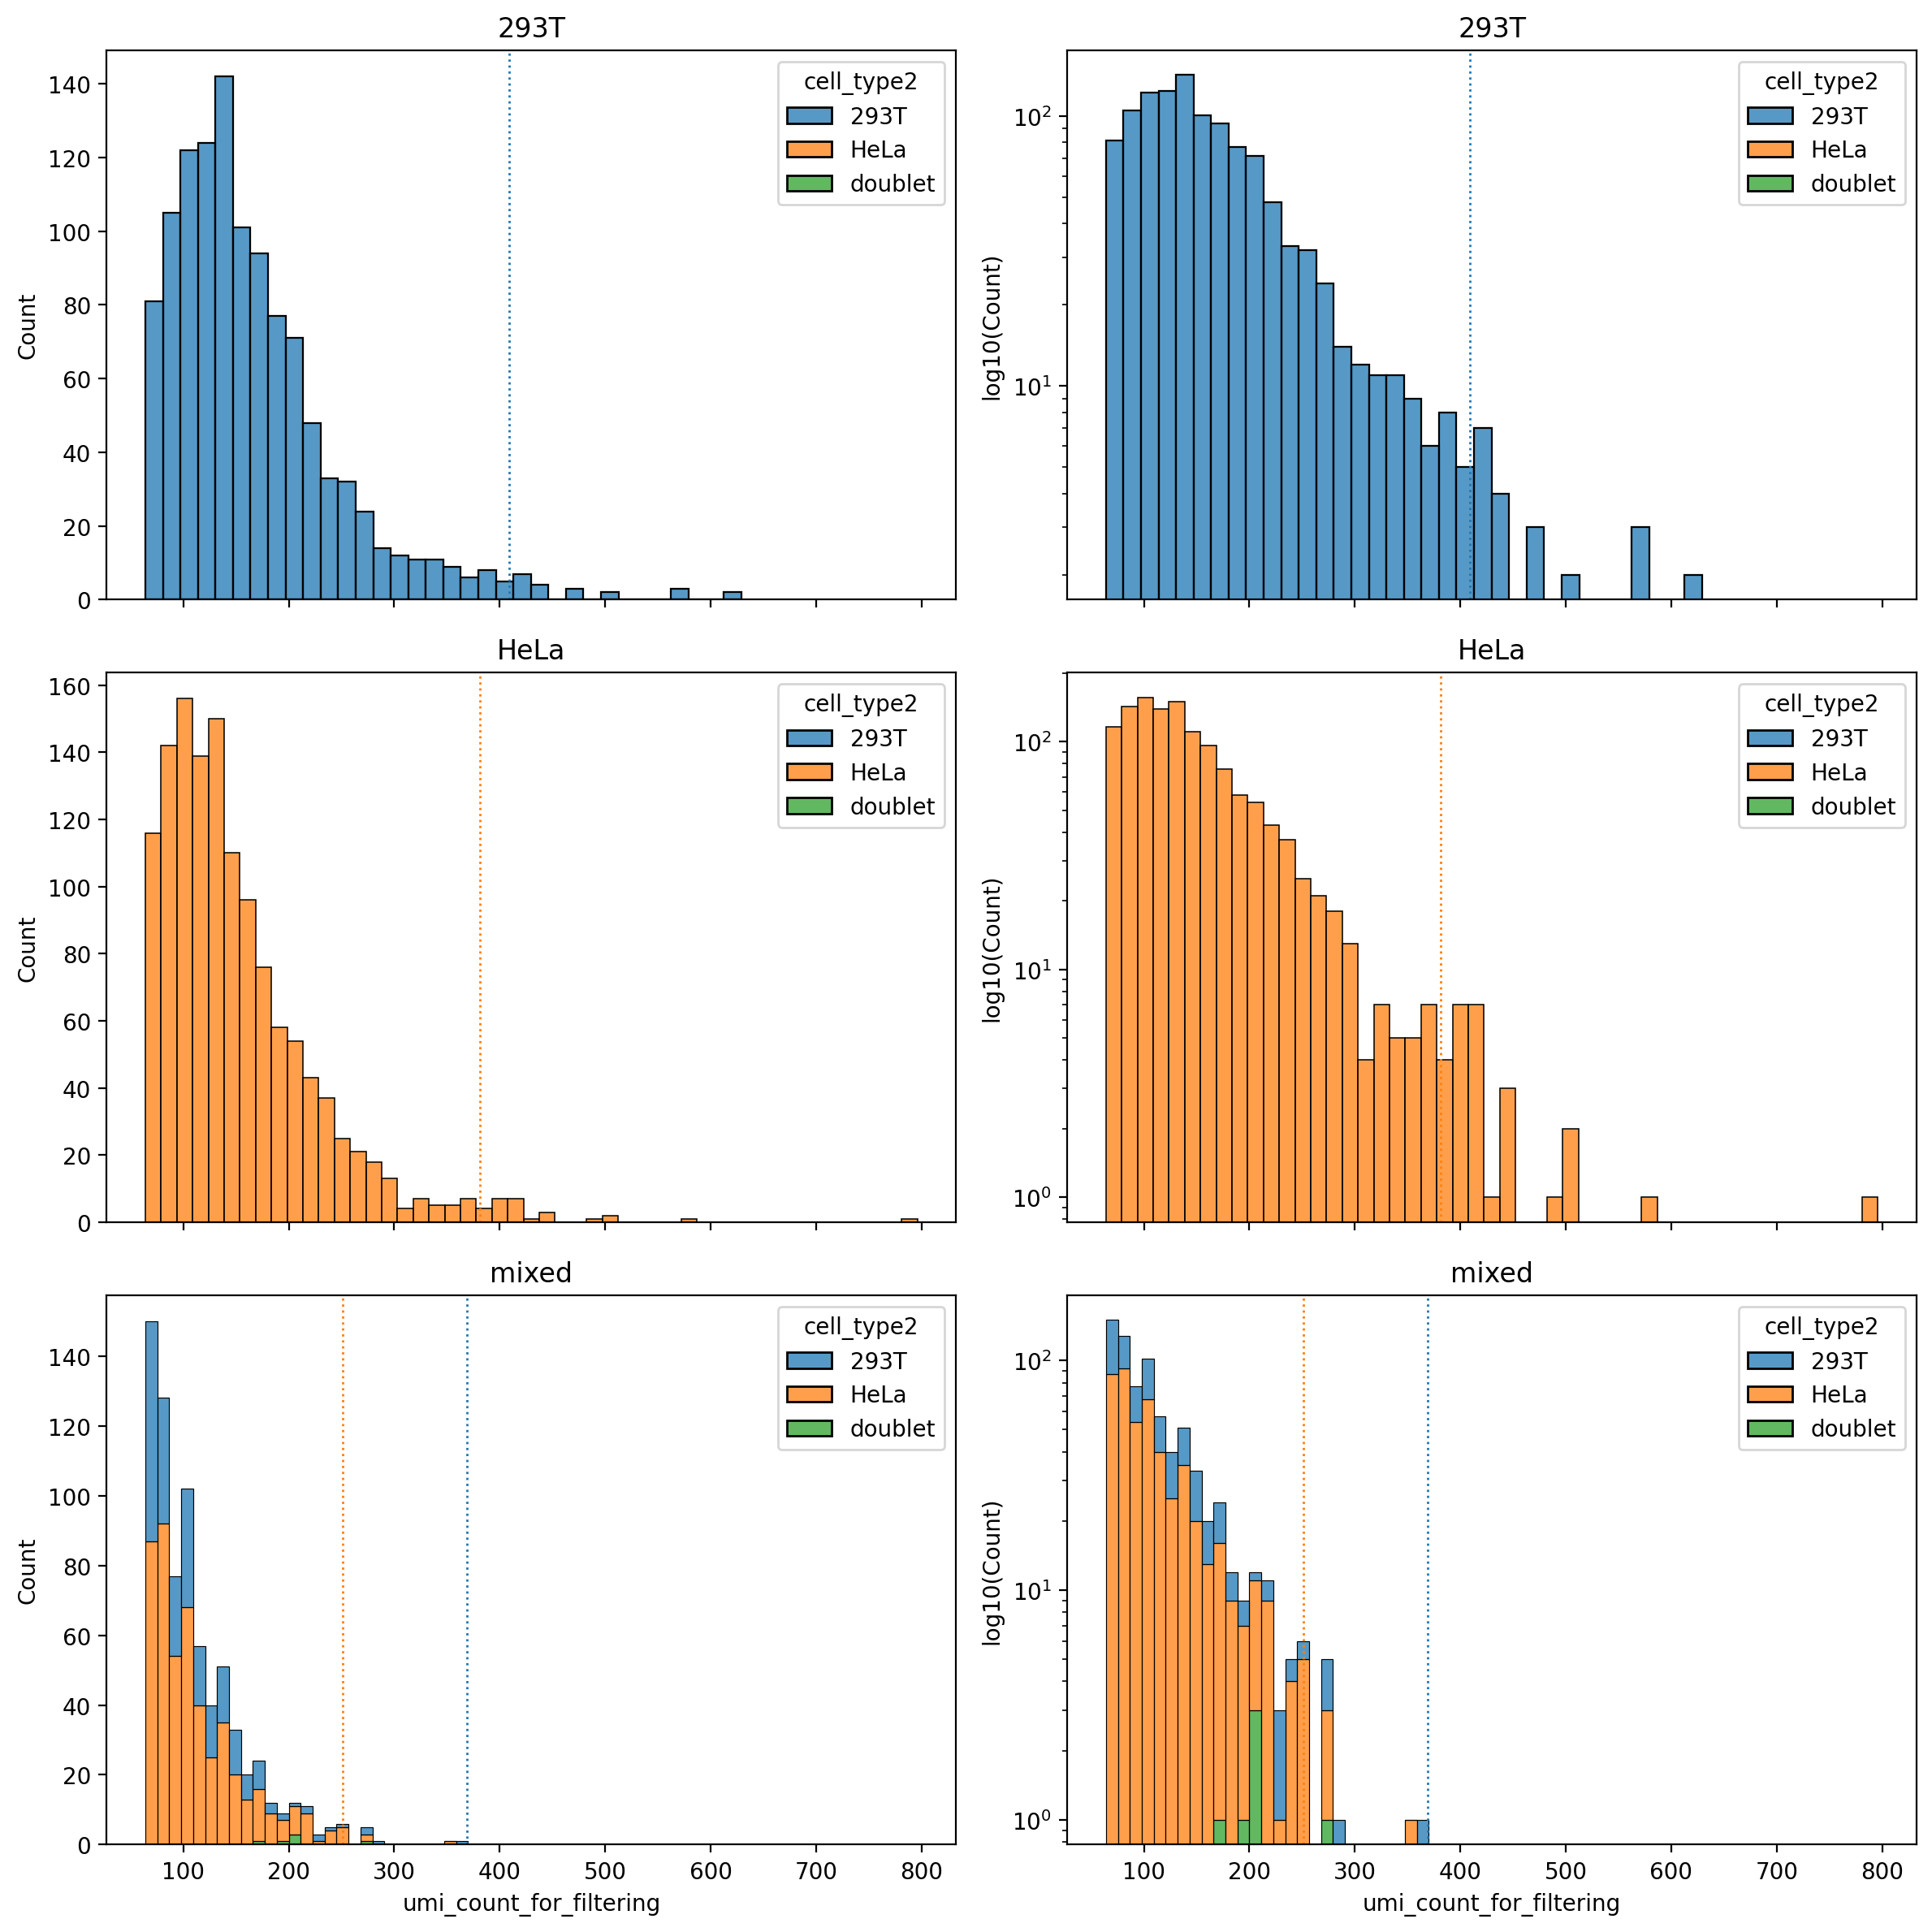

In [42]:
fig, axes = pyplot.subplots(nrows=3, ncols=2, figsize=(12,12), sharex=True)

color_dict = {'293T':'C0',
              'HeLa':'C1'}

for ax_idx, condition in enumerate(['293T', 'HeLa', 'mixed']):
    to_plot = valid_cells[valid_cells['condition'] == condition]

    #raw count histogram
    seaborn.histplot(data=to_plot, x='umi_count_for_filtering', hue='cell_type2', 
                     multiple='stack', discrete=False, ax=axes[ax_idx,0])
    for ct, thresh in pct_umi_thresh_df.loc[pct_umi_thresh_df['condition'] == condition, ['ct', 'umi_threshold']].to_numpy():
        axes[ax_idx,0].axvline(thresh, color=color_dict[ct], linewidth=1, linestyle='dotted')
    axes[ax_idx,0].set_title(condition)
    
    #log count histogram
    seaborn.histplot(data=to_plot, x='umi_count_for_filtering', hue='cell_type2', 
                     multiple='stack', discrete=False, ax=axes[ax_idx,1])
    for ct, thresh in pct_umi_thresh_df.loc[pct_umi_thresh_df['condition'] == condition, ['ct', 'umi_threshold']].to_numpy():
        axes[ax_idx,1].axvline(thresh, color=color_dict[ct], linewidth=1, linestyle='dotted')
    axes[ax_idx,1].set_yscale('log')
    axes[ax_idx,1].set_ylabel('log10(Count)')
    axes[ax_idx,1].set_title(condition)

fig.tight_layout()

The doublet cells are on the high end of the UMI coverage distribution, but they are not uniformly at the top. We conclude that the doublet contamination is low enough that the risk of removing true cells outweighs the risk of homotypic doublets influencing downstream results, and will not attempt to filter homotypic doublets.

### Compute coverage per cell statistics

In [43]:
drop_dups['cell_id'] = drop_dups['well_id'] + '-' + drop_dups['bc1_corr'] + '-' + drop_dups['bc2_corr']
reads_per_cell = drop_dups.groupby('cell_id')['read_count'].sum().rename('read_count')
print('Avg reads per cell:', reads_per_cell[reads_per_cell.index.isin(valid_cells['cell_id'])].mean())
print('Med reads per cell:', reads_per_cell[reads_per_cell.index.isin(valid_cells['cell_id'])].median())

Avg reads per cell: 3619.621571072319
Med reads per cell: 3212.5


In [44]:
print('Avg UMIs per cell:', valid_cells['umi_count'].mean())
print('Med UMIs per cell:', valid_cells['umi_count'].median())

Avg UMIs per cell: 148.07263092269326
Med UMIs per cell: 130.0


## Save valid cells again with updated attributes

In [45]:
valid_cells.to_csv('heteroplasmy_dataframe.cell_annots_added.csv', index=False, sep=',')

## Try SPLiT-seq style downsampling of reads

Based on Fig S3 from [Rosenberg et al. _Science_. 2018.](https://doi.org/10.1126/science.aam8999)

In [46]:
identified_reads = drop_dups[(drop_dups['edit_type'] != 'UNKNOWN')
                             & (drop_dups['condition'] != 'UNKNOWN')
                             & (drop_dups['bc2_corr'] != 'UNKNOWN')].copy()
identified_reads['cell_id'] = identified_reads['well_id'] + '-' + identified_reads['bc1_corr'] + '-' + identified_reads['bc2_corr']
identified_reads['cell_umi'] = identified_reads['cell_id'] + '_' + identified_reads['umi']
identified_umis = identified_reads.groupby(['cell_id', 'cell_umi', 'umi'])['read_count'].sum().rename('read_count').reset_index()
identified_umis = identified_umis[identified_umis['read_count'] > 1]
print(identified_umis.shape)

(529188, 4)


In [47]:
identified_umis.head()

,cell_id,cell_umi,umi,read_count
15,A1-AAACATCG-CTAACGAG,A1-AAACATCG-CTAACGAG_AACTATCACG,AACTATCACG,29
16,A1-AAACATCG-CTAACGAG,A1-AAACATCG-CTAACGAG_AAGTCTGGCT,AAGTCTGGCT,24
17,A1-AAACATCG-CTAACGAG,A1-AAACATCG-CTAACGAG_AATATTAGAG,AATATTAGAG,26
18,A1-AAACATCG-CTAACGAG,A1-AAACATCG-CTAACGAG_AATTTTCTCC,AATTTTCTCC,20
19,A1-AAACATCG-CTAACGAG,A1-AAACATCG-CTAACGAG_ACCCGGTGTT,ACCCGGTGTT,31


In [48]:
identified_umis['valid_cell'] = identified_umis['cell_id'].isin(valid_cells['cell_id'])
identified_umis_cells = identified_umis[identified_umis['valid_cell']]

In [49]:
mean_reads_per_cell = identified_umis_cells.groupby('cell_id')['read_count'].sum().mean()
print(mean_reads_per_cell)

3576.150872817955


### Downsample the number of reads per cell and keep track of the effect on the number of UMIs detected per cell

In [50]:
read_depths = numpy.arange(0,int(mean_reads_per_cell),50)
downsampling_res = {'reads_per_cell':read_depths, 'umis_per_cell':[]}
for read_depth in read_depths:
    subsample_fraction = read_depth/mean_reads_per_cell
    sub_sampled_counts = numpy.random.binomial(identified_umis_cells['read_count'], subsample_fraction)
    downsampling_res['umis_per_cell'].append(identified_umis_cells[sub_sampled_counts > 0]
                                             .groupby('cell_id')['umi']
                                             .size()
                                             .median())
read_depths = pandas.DataFrame(downsampling_res).fillna(0)
read_depths.head()

,reads_per_cell,umis_per_cell
0,0,0.0
1,50,37.0
2,100,62.0
3,150,80.0
4,200,92.0


### Plot the results

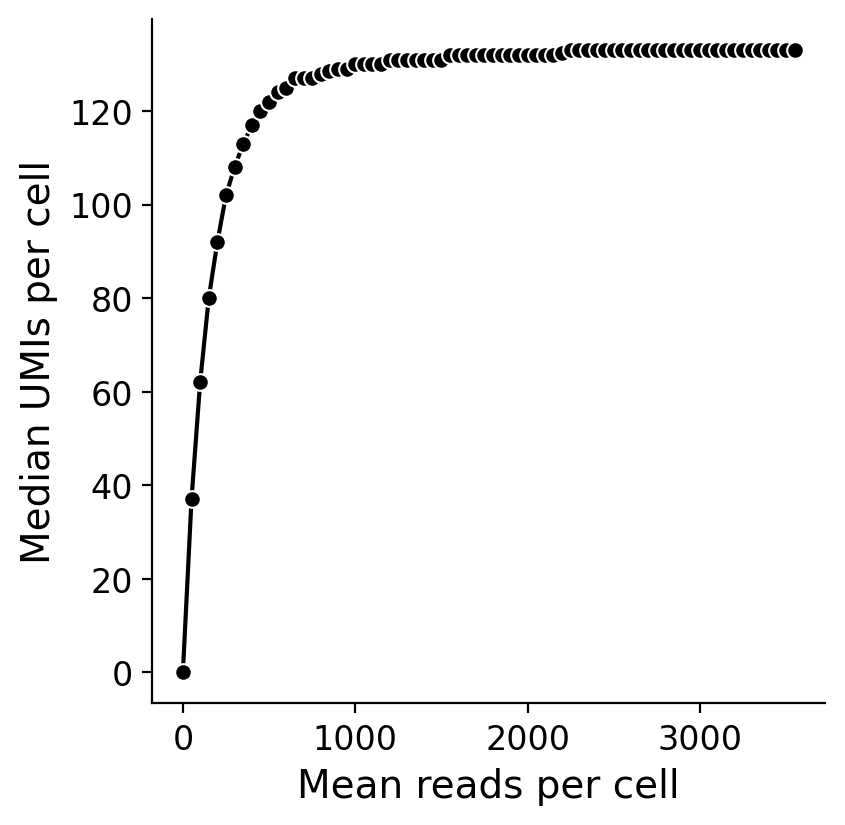

In [51]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(4,4))
seaborn.lineplot(data=read_depths, x='reads_per_cell', y='umis_per_cell', marker='o', color='k', ax=axes)
axes.tick_params(labelsize=12)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_ylabel('Median UMIs per cell', fontsize=14)
axes.set_xlabel('Mean reads per cell', fontsize=14)
fig.savefig('./barnyard_read_downsampling.pdf', bbox_inches='tight')
fig.tight_layout()